In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image_path = "                 "
img = cv2.imread(image_path)
image = cv2.resize(img, (1280, 720))

In [3]:
def binarize_image(image):
    
    """
    Function to binarize the input image using a threshold of 127.

    Args:
    - image: input image

    Returns:
    - binary: binary image after thresholding
    """
    
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary

def bird_eye_view(image, src_mask, dst_mask):
    
    """
    Function to perform bird's eye view perspective transformation on the input image.
    
    Args:
    - image: input image
    - src_mask: source points for perspective transformation
    - dst_mask: destination points for perspective transformation

    Returns:
    - warped_img: perspective-transformed image
    - matrix: transformation matrix
    """
    
    matrix = cv2.getPerspectiveTransform(src_mask, dst_mask)
    warped_img = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]))
    return warped_img, matrix

def image_processing_pipeline(image, src_mask, dst_mask):
    
    """
    Function to process the input image through a series of steps including color space conversion,
    edge detection, perspective transformation, and binarization.

    Args:
    - image: input image
    - src_mask: source points for perspective transformation
    - dst_mask: destination points for perspective transformation

    Returns:
    - binary_warped: binary image after perspective transform and binarization
    - matrix: transformation matrix
    """
    
    # Convert image to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    # Extract the L channel (brightness) from HLS
    l_channel = hls[:, :, 1] 
    # Apply Prewitt edge detection along x-axis
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    prewitt_edges = cv2.filter2D(l_channel, -1, kernelx)
    # Perform bird's eye view perspective transformation
    warped_img, matrix = bird_eye_view(prewitt_edges, src_mask, dst_mask)
    # Binarize the transformed image
    binary_warped = binarize_image(warped_img)
    return binary_warped, matrix

def sliding_windows(binary_warped, nwindows=9):
    
    """
    Function to implement sliding window technique for lane detection.
    
    Args:
    - binary_warped: binary image after perspective transform
    - nwindows: number of sliding windows
    
    Returns:
    - left_fit: coefficients of the left lane line polynomial
    - right_fit: coefficients of the right lane line polynomial
    - lefty: y-coordinates of the left lane pixels
    - leftx: x-coordinates of the left lane pixels
    - righty: y-coordinates of the right lane pixels
    - rightx: x-coordinates of the right lane pixels
    - msk: image with sliding windows and detected lane pixels visualized
    """
    
    # Set parameters
    margin=100
    minpix=50
    
    # Calculate histogram
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:], axis=0)
    midpoint = int(histogram.shape[0] / 2) 
    left_base = np.argmax(histogram[:midpoint]) 
    right_base = np.argmax(histogram[midpoint:]) + midpoint 
    
    # Set up sliding windows
    window_height = int(binary_warped.shape[0] / nwindows) 
    nonzero = binary_warped.nonzero() 
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_current = left_base
    right_current = right_base
    left_lane_inds = []
    right_lane_inds = []

    msk = np.dstack((binary_warped, binary_warped, binary_warped)) * 255  

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height  
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = left_current - margin 
        win_xleft_high = left_current + margin 
        win_xright_low = right_current - margin
        win_xright_high = right_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            left_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_current = int(np.mean(nonzerox[good_right_inds]))

        cv2.rectangle(msk, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(msk, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds] 
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds] 
    righty = nonzeroy[right_lane_inds] 
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    msk[lefty, leftx] = [0, 0, 255]
    msk[righty, rightx] = [0, 0, 255]

    return left_fit, right_fit, lefty, leftx, righty, rightx, msk

def draw_lane_pipeline(image, binary_warped, matrix, left_fit, right_fit):
    
    """
    Function to draw detected lane on the original image, calculate lane center and vehicle steering angle,
    and annotate the image with this information.

    Args:
    - image: original input image
    - binary_warped: binary image after perspective transform and binarization
    - matrix: perspective transformation matrix
    - left_fit: coefficients of the polynomial fit for the left lane line
    - right_fit: coefficients of the polynomial fit for the right lane line

    Returns:
    - add_image: original image annotated with detected lane, lane center, and vehicle steering angle
    """
    
    # Generate y values for plotting along the lane
    plot_y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    
    # Generate x values for left and right lanes using polynomial coefficients
    left_fit_x = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    right_fit_x = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]

    # Create arrays for left and right lane points
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
    pts = np.int32(np.hstack((pts_left, pts_right)))

    # Create an image with lanes filled in
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_zero = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.fillPoly(color_zero, pts, (0, 255, 0))

    # Inverse perspective transform to overlay lanes on original image
    inverse_matrix = np.linalg.inv(matrix)
    inverse_warped_img = cv2.warpPerspective(color_zero, inverse_matrix, (image.shape[1], image.shape[0]))
    add_image = cv2.addWeighted(image, 1, inverse_warped_img, 1, 0)

    # Calculate lane center and annotate the image
    left_base = left_fit[0] * (binary_warped.shape[0] - 1)**2 + left_fit[1] * (binary_warped.shape[0] - 1) + left_fit[2]
    right_base = right_fit[0] * (binary_warped.shape[0] - 1)**2 + right_fit[1] * (binary_warped.shape[0] - 1) + right_fit[2]
    lane_center = left_base + (right_base - left_base) // 2
    midpoint = image.shape[1] // 2
    difference = (midpoint - lane_center) * 3.25 / 720  # Lane width of 3.25m, lane width of 720 pixels
    line_length = 100
    line_height = 680

    # Display center line and lane center circle
    x1 = int(left_base + line_length)
    x2 = int(right_base - line_length)
    y1 = y2 = int(line_height)

    j1 = j2 = int(lane_center)
    k1 = int(line_height - 30)
    k2 = int(line_height + 30)

    cv2.line(add_image, (x1, y1), (x2, y2), (0, 0, 0), thickness=4)
    cv2.line(add_image, (j1, k1), (j2, k2), (0, 0, 0), thickness=4)
    cv2.circle(add_image, (midpoint, line_height), radius=25, color=(0, 0, 255), thickness=3)

    # Annotate the image with vehicle offset from center and steering angle
    dx = lane_center - midpoint
    dy = image.shape[0] - line_height
    angle = np.arctan(dx / dy) * 180 / np.pi  # Convert angle to degrees
    max_steering_angle = 900  # Maximum steering angle with two turns as reference (900 degrees)
    steering_angle = (angle / max_steering_angle) * 100  # Percentage of the maximum steering angle

    cv2.putText(add_image,
                "Car is " + str(round(difference, 2)) + ' m off center',
                (700, 50),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (255, 255, 255), 2)

    cv2.putText(add_image,
                f"Steering Angle: {steering_angle:.2f} degrees",
                (700, 100),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (255, 255, 255), 2)

    return add_image

In [4]:
# Step 1: Copy the input image to avoid modifying the original
image = np.copy(image)

In [5]:
# Step 2: Initial setup for perspective transformation
top_left = (559, 556)
bottom_left = (374, 680)
top_right = (732, 555)
bottom_right = (943, 680)

src_mask = np.array([top_left, bottom_left, top_right, bottom_right], dtype=np.float32)
dst_mask = np.array([[0, 0], [0, 720], [1280, 0], [1280, 720]], dtype=np.float32)

In [6]:
# Step 3: Execute image processing pipeline and get binary warped image and transformation matrix
binary_warped, matrix = image_processing_pipeline(image, src_mask, dst_mask)

In [7]:
# Step 4: Execute sliding windows technique to detect lane lines and get polynomial fits
left_fit, right_fit, lefty, leftx, righty, rightx, msk = sliding_windows(binary_warped, nwindows=9)

In [8]:
# Step 5: Use the perspective-transformed image directly and place it in the top-left corner
small_warped = cv2.resize(msk, (320, 180))

In [9]:
# Step 6: Draw detected lanes on the original image, calculate lane center, and annotate the image with steering angle
lane_result = draw_lane_pipeline(image, binary_warped, matrix, left_fit, right_fit)
lane_result[0:180, 0:320] = small_warped

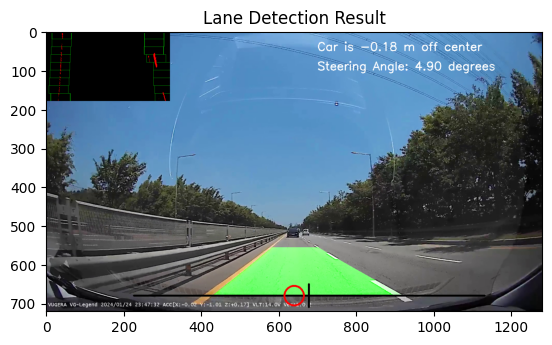

In [10]:
plt.imshow(cv2.cvtColor(lane_result, cv2.COLOR_BGR2RGB))
plt.title('Lane Detection Result')
plt.show()